In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

torch.manual_seed(123)

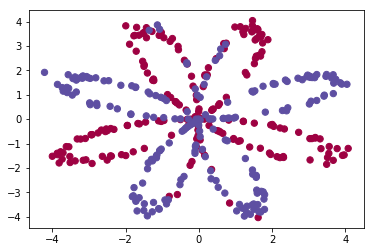

In [2]:
# 构造二分类数据，直接采用参考文档的代码写的
np.random.seed(1)
m = 400       # 样本数量
N = int(m/2)  # 每一类的点的个数
D = 2         # 特征维度
x_train = np.zeros((m, D), dtype=np.float32)
y_train = np.zeros((m, 1), dtype=np.float32) # label 向量，0 表示红色，1 表示蓝色
a = 4         # 特征的"最大值"

for j in range(2):
    ix = range(N * j, N * (j + 1))
    t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2 # theta
    r = a * np.sin(4 * t) + np.random.randn(N) * 0.2 # radius
    x_train[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y_train[ix] = j
# 数据点图    
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.reshape(-1), s=40, cmap=plt.cm.Spectral)

x_train = Variable(torch.from_numpy(x_train))
y_train = Variable(torch.from_numpy(y_train))

##### 先使用手动构建神经网络，网络结构见图：简单神经网络结构.png

In [3]:
# 定义网络参数并初始化
w1 = nn.Parameter(torch.randn(2, 4))
b1 = nn.Parameter(torch.randn(4))

w2 = nn.Parameter(torch.randn(4, 1))
b2 = nn.Parameter(torch.randn(1))

# 定义网络模型
def two_net(x):
    hidden = torch.mm(x, w1) + b1
    h = torch.tanh(hidden)
    out = torch.mm(h, w2) + b2
    return out

# 声明损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD([w1, b1, w2, b2], lr=1.)

In [4]:
# 定义计算准确率函数
def compute_acc(out, y):
    y = y.data.numpy()
    out = out.data.numpy()
    num = 0
    for i in range(len(y)):
        if out[i] == y[i]:
            num += 1
    return num / len(y)

In [5]:
# 训练模型
Epochs = 2000
for epoch in range(Epochs):
    y_ = two_net(x_train)
    loss = criterion(y_, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 用现在的模型对数据进行预测，得到准确率
    y_pred = two_net(x_train)
    out = torch.sigmoid(y_pred)
    out = (out > 0.5).type(torch.FloatTensor) # 将大于0.5的值改成1，小于0.5的改成0
    acc = compute_acc(out, y_train)
    if (epoch + 1) % 50 == 0:
        print('epoch: {:4d}, loss: {:.4f}, acc: {:.4f}'.format(epoch + 1, loss.data.item(), acc))

epoch:   50, loss: 0.6090, acc: 0.6275
epoch:  100, loss: 0.5988, acc: 0.6300
epoch:  150, loss: 0.5944, acc: 0.6300
epoch:  200, loss: 0.5918, acc: 0.6325
epoch:  250, loss: 0.5899, acc: 0.6350
epoch:  300, loss: 0.5884, acc: 0.6350
epoch:  350, loss: 0.5870, acc: 0.6325
epoch:  400, loss: 0.5853, acc: 0.6325
epoch:  450, loss: 0.5604, acc: 0.6900
epoch:  500, loss: 0.3416, acc: 0.8675
epoch:  550, loss: 0.3250, acc: 0.8700
epoch:  600, loss: 0.3163, acc: 0.8700
epoch:  650, loss: 0.3107, acc: 0.8775
epoch:  700, loss: 0.3066, acc: 0.8825
epoch:  750, loss: 0.3034, acc: 0.8825
epoch:  800, loss: 0.3008, acc: 0.8850
epoch:  850, loss: 0.2987, acc: 0.8925
epoch:  900, loss: 0.2968, acc: 0.8925
epoch:  950, loss: 0.2951, acc: 0.8975
epoch: 1000, loss: 0.2936, acc: 0.8975
epoch: 1050, loss: 0.2922, acc: 0.8950
epoch: 1100, loss: 0.2910, acc: 0.8950
epoch: 1150, loss: 0.2898, acc: 0.8975
epoch: 1200, loss: 0.2887, acc: 0.8975
epoch: 1250, loss: 0.2877, acc: 0.8975
epoch: 1300, loss: 0.2867

#### Sequential
##### 以上我们手动构建了一个2层的网络，其中参数需要手动地定义，当参数非常多的时候手动方法就显得非常麻烦了。因此，我们将采用PyTorch中的Sequential和Module来定义网络（模型），这样更加的方便。下面首先介绍Sequential

In [6]:
seq_net = nn.Sequential(
          nn.Linear(2, 4), # nn.Linear(in_feature, out_feature)，相当于 wx + b
          nn.Tanh(),       # 激活函数
          nn.Linear(4, 1))
# 数据就是按照定义的层的顺序进行计算的

In [7]:
# 序列模块可以通过索引访问每一层，索引从0开始
seq_net

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [8]:
seq_net[0]

Linear(in_features=2, out_features=4, bias=True)

In [9]:
# 打印第一层的权重
w0 = seq_net[0].weight
print(w0)
# 由此可以看到网络中的参数默认是需要求导数的

Parameter containing:
tensor([[-0.5980, -0.2029],
        [-0.4980,  0.0467],
        [-0.1320, -0.3793],
        [-0.0643,  0.6699]], requires_grad=True)


In [10]:
# 打印第一层的偏置
b0 = seq_net[0].bias
print(b0)

Parameter containing:
tensor([-0.0558,  0.0225, -0.1103,  0.1112], requires_grad=True)


In [11]:
# 通过.parameters()可以获得模型的参数
param = seq_net.parameters()
# 定义优化器
optimizer = torch.optim.SGD(param, lr=1.)

In [12]:
# 训练模型
Epochs = 2000
for epoch in range(Epochs):
    y_ = seq_net(x_train)
    loss = criterion(y_, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 用现在的模型对数据进行预测，得到准确率
    y_pred = seq_net(x_train)
    out = torch.sigmoid(y_pred)
    out = (out > 0.5).type(torch.FloatTensor) # 将大于0.5的值改成1，小于0.5的改成0
    acc = compute_acc(out, y_train)
    if (epoch + 1) % 50 == 0:
        print('epoch: {:4d}, loss: {:.4f}, acc: {:.4f}'.format(epoch + 1, loss.data.item(), acc))

epoch:   50, loss: 0.4290, acc: 0.8675
epoch:  100, loss: 0.3620, acc: 0.8600
epoch:  150, loss: 0.3414, acc: 0.8675
epoch:  200, loss: 0.3306, acc: 0.8675
epoch:  250, loss: 0.3235, acc: 0.8700
epoch:  300, loss: 0.3183, acc: 0.8700
epoch:  350, loss: 0.3143, acc: 0.8750
epoch:  400, loss: 0.3111, acc: 0.8800
epoch:  450, loss: 0.3084, acc: 0.8800
epoch:  500, loss: 0.3061, acc: 0.8825
epoch:  550, loss: 0.3042, acc: 0.8850
epoch:  600, loss: 0.3024, acc: 0.8825
epoch:  650, loss: 0.3008, acc: 0.8825
epoch:  700, loss: 0.2994, acc: 0.8850
epoch:  750, loss: 0.2981, acc: 0.8850
epoch:  800, loss: 0.2969, acc: 0.8875
epoch:  850, loss: 0.2958, acc: 0.8850
epoch:  900, loss: 0.2948, acc: 0.8850
epoch:  950, loss: 0.2938, acc: 0.8875
epoch: 1000, loss: 0.2929, acc: 0.8875
epoch: 1050, loss: 0.2920, acc: 0.8875
epoch: 1100, loss: 0.2912, acc: 0.8900
epoch: 1150, loss: 0.2904, acc: 0.8900
epoch: 1200, loss: 0.2897, acc: 0.8900
epoch: 1250, loss: 0.2889, acc: 0.8900
epoch: 1300, loss: 0.2882

#### 在介绍Module之前，先介绍以下如何保存和加载模型

In [13]:
# 1、将参数和模型结构保存在一起
torch.save(seq_net, 'save_seq_net.pth')
# torch.save(模型, 参数保存的路径)

In [14]:
# 加载模型，torch.load(模型路径)
seq_net1 = torch.load('save_seq_net.pth')
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
# 2、只保存参数而不保存模型结构
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

#### 通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数

In [16]:
seq_net2 = nn.Sequential(
           nn.Linear(2, 4),
           nn.Tanh(),
           nn.Linear(4, 1))
seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
seq_net2[0].weight

Parameter containing:
tensor([[-4.1532, -4.9404],
        [-2.6015,  4.5765],
        [ 4.7243, -5.9515],
        [ 0.0123,  4.6847]], requires_grad=True)

#### Module
#### 定义Module是有模板的，见：Module模板.png

In [18]:
# 下面使用Module实现上面的模型
class module_net(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(module_net, self).__init__()
        # 定义模型有哪些层
        self.layer1 = nn.Linear(input_num, hidden_num)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(hidden_num, output_num)
    # 前向传播过程
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [19]:
mo_net = module_net(2, 4, 1)

In [20]:
# 可以通过名字（属性）访问模型的某一层
mo_net.layer1

Linear(in_features=2, out_features=4, bias=True)

In [21]:
# 获取模型的参数
param = mo_net.parameters()
# 定义优化器
optimizer = torch.optim.SGD(param, lr=1.)

In [22]:
# 训练模型
Epochs = 2000
for epoch in range(Epochs):
    y_ = mo_net(x_train)
    loss = criterion(y_, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 用现在的模型对数据进行预测，得到准确率
    y_pred = mo_net(x_train)
    out = torch.sigmoid(y_pred)
    out = (out > 0.5).type(torch.FloatTensor) # 将大于0.5的值改成1，小于0.5的改成0
    acc = compute_acc(out, y_train)
    if (epoch + 1) % 50 == 0:
        print('epoch: {:4d}, loss: {:.4f}, acc: {:.4f}'.format(epoch + 1, loss.data.item(), acc))

epoch:   50, loss: 0.5733, acc: 0.7950
epoch:  100, loss: 0.3804, acc: 0.8575
epoch:  150, loss: 0.3466, acc: 0.8750
epoch:  200, loss: 0.3324, acc: 0.8750
epoch:  250, loss: 0.3240, acc: 0.8775
epoch:  300, loss: 0.3182, acc: 0.8775
epoch:  350, loss: 0.3138, acc: 0.8750
epoch:  400, loss: 0.3104, acc: 0.8775
epoch:  450, loss: 0.3075, acc: 0.8800
epoch:  500, loss: 0.3051, acc: 0.8825
epoch:  550, loss: 0.3030, acc: 0.8850
epoch:  600, loss: 0.3011, acc: 0.8875
epoch:  650, loss: 0.2995, acc: 0.8875
epoch:  700, loss: 0.2980, acc: 0.8875
epoch:  750, loss: 0.2966, acc: 0.8875
epoch:  800, loss: 0.2954, acc: 0.8875
epoch:  850, loss: 0.2942, acc: 0.8925
epoch:  900, loss: 0.2932, acc: 0.8925
epoch:  950, loss: 0.2922, acc: 0.8950
epoch: 1000, loss: 0.2912, acc: 0.8975
epoch: 1050, loss: 0.2903, acc: 0.8975
epoch: 1100, loss: 0.2895, acc: 0.9000
epoch: 1150, loss: 0.2887, acc: 0.8975
epoch: 1200, loss: 0.2879, acc: 0.8975
epoch: 1250, loss: 0.2872, acc: 0.8975
epoch: 1300, loss: 0.2865